# ISC analysis with levels

Remark: could be the most promising.

`beta_series glm25 subj* nosmooth`

## Main goals

The BOLD signal contains noise. Here, we calculate correlations between subjects to reduce noise and estimate task-relevant signals. Want to find brain regions where the same levels of activity are displayed. Key predictions are that, in the theory encoding region, the ISC should:

1. Be highest for same levels, medium for same games, and lowest for random (shuffled) games
2. Increase over levels of the same game

---

## Outline

0. Load data in
1. Preprocess data
2. Reorder BOLD data based on names
3. ISC

In [1]:
import h5py
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import hdf5storage
import mat73
import pandas as pd

%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 30 seconds


# 0. Load in data


In [2]:
data_dir = '/Users/Daphne/Desktop/beta_series/' # local directory
# specify filename
filename = 'beta_series_glm25_subj1_nosmooth.mat'

os.path.exists(data_dir) 

True

In [3]:
# each subject is a separate file so
subject = h5py.File(data_dir+filename,'r')

list(subject.keys()) # these are the variables in the data

['#refs#', 'B', 'Vmask', 'mask', 'names']

In [4]:
def decode_variable(file, item):

    '''
    Converts matlab cell array in the form "<HDF5 object reference>" to list of strings.

    IN

    file: the path + filename 
    item: the variable in the dataset that needs to be decoded

    RETURNS

    readable_data: np array of strings
    '''

    # Open file                                                                                    
    myfile = h5py.File(file,'r')
    variable = myfile[item] # get the names variable

    readable_data = [] # store the ne


    for var in variable: # encode and decode the objects, 18 per subject
        for v in var: # Read the references  

            #print(v)
            ds = myfile[v]
            #print(ds)
            data = ds[:]

            # store the decoded data
            word = []
            
            for i in data:
                letter = str(chr(i))  # the chr() function returns the character that represents the specified unicode.
                word.append(letter)
            word = ''.join(word) # join list of strings
            
            readable_data.append(word)
            
    return np.array(readable_data)

In [5]:
num_subjects = 8

B_data = []
mask_data = []
Vmask_data = []
names_data = []

for i in range(num_subjects):
    idx = i+1
    
    # change filename to subject #
    data_dir = '/Users/Daphne/Desktop/beta_series/'
    filename = 'beta_series_glm25_subjk_nosmooth.mat'
    filename = filename.replace('k', str(idx))
    
    subject = h5py.File(data_dir+filename,'r') 
    print(f'Get data for subject {idx}')
    # load and save data for respective subject
    B = subject['B'].value
    mask = subject['mask'].value
    Vmask = subject['Vmask']
    
    # === decode level names ===
    names = decode_variable(data_dir+filename, 'names')
    
    # append to lists
    B_data.append(B)
    mask_data.append(mask)
    Vmask_data.append(Vmask)
    names_data.append(names)

Get data for subject 1
Get data for subject 2
Get data for subject 3
Get data for subject 4
Get data for subject 5
Get data for subject 6
Get data for subject 7
Get data for subject 8


In [6]:
B_data[0].shape # voxels x levels

(179595, 54)

In [7]:
mask_data[0].shape

(79, 95, 79)

In [8]:
names_data[0].shape # 54 levels (18 blocks x 3 levels per block)

(54,)

In [83]:
print(names_data[0][0:10])

['Sn(1) vgfmri3_chase_run_1_block_1_instance_1*bf(1)'
 'Sn(1) vgfmri3_chase_run_1_block_1_instance_2*bf(1)'
 'Sn(1) vgfmri3_chase_run_1_block_1_instance_3*bf(1)'
 'Sn(1) vgfmri3_lemmings_run_1_block_2_instance_1*bf(1)'
 'Sn(1) vgfmri3_lemmings_run_1_block_2_instance_2*bf(1)'
 'Sn(1) vgfmri3_lemmings_run_1_block_2_instance_3*bf(1)'
 'Sn(1) vgfmri3_bait_run_1_block_3_instance_1*bf(1)'
 'Sn(1) vgfmri3_bait_run_1_block_3_instance_2*bf(1)'
 'Sn(1) vgfmri3_bait_run_1_block_3_instance_3*bf(1)'
 'Sn(2) vgfmri3_plaqueAttack_run_2_block_1_instance_1*bf(1)']


# 1. Preprocessing

1. Clean the level name strings

2. Reorder the BOLD data

    - split the list of strings `names` into 3 parts: `game, level, session`.
    - sort the data first by game, then level, then session (default = quicksort)
    
<font color=red>TODO: check if the reordering is the same among all matrices.</font>

In [9]:
def cleanup_names(s):
    '''
    Removes parts of the string to make it more orderly and easier to rearrange.
    '''
    for r in (('vgfmri3_', ''), ('*bf(1)', ''), ('_instance_', ' ')):
        s = s.replace(*r)
        
    return s

In [10]:
def get_in_shape(B_s, names_s):
    
    '''
    Massages data into right shape to perform ISC: [TRs, voxels, subjects] - bunch of stacked matrices
    
    IN
    
    B: the bold data for subject s
    names: the order of the levels for subject s
    
    OUT
    
    dfOrdered: the ordered df, just to sanity check the reordering
    B_ordered: the ordered B array [levels, voxels]
    '''
    
    # --- clean up names --- # 
    clean_names = []

    for name in names_s:
        stripped_name = cleanup_names(name)
        clean_names.append(stripped_name)
        
    # --- split string at each white space --- #
    splitted = [words for segments in clean_names for words in segments.split(' ')] 
    # store sessions, games and levels in separate lists 
    sessions = splitted[0::3] # get item 0,3,6,9 etc.
    games = splitted[1::3] # get item 1,4,7,10 etc.
    levels = splitted[2::3] # get item 2,5,8 etc.

    # --- read in B as pandas df --- #
    df = pd.DataFrame(B_s)
    df.insert(0, 'game', games) # insert block names as first col
    df.insert(1, 'level', levels) # insert levels as second col
    df.insert(2, 'session', sessions) 
    
    # Sort by game name, then level, then session
    dfOrdered = df.sort_values(by=['game','level','session'], ascending=True) # return to check if order is the same
    
    dfBold = dfOrdered.drop(['game','level','session',], axis=1) # don't need these columns anymore, got the Betas in the same order.
    B_ordered = dfBold.values # convert df to numpy array
    
    return clean_names, dfOrdered, B_ordered

In [12]:
ISC_data = []
ordered_dfs = []
clean_names_arr = [] 

for s in range(num_subjects):
    
    print(f'Preprocess fMRI data for subject {s+1}')
    # get the betas and game order from this
    B_s = B_data[s].T # transpose to get [blocks, voxels]
    names_s = names_data[s]
    
    level_names, dfOrdered, B_ordered = get_in_shape(B_s, names_s)
    
    ISC_data.append(B_ordered)
    ordered_dfs.append(dfOrdered)
    clean_names_arr.append(level_names)
    
ISC_arr = np.array(ISC_data)

Preprocess fMRI data for subject 1
Preprocess fMRI data for subject 2
Preprocess fMRI data for subject 3
Preprocess fMRI data for subject 4
Preprocess fMRI data for subject 5
Preprocess fMRI data for subject 6
Preprocess fMRI data for subject 7
Preprocess fMRI data for subject 8


Check if the ordering went well

In [13]:
ordered_dfs[0].head(5)

,game,level,session,0,1,2,3,4,5,6,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
6,bait_run_1_block_3,1,Sn(1),19.199156,28.537733,10.239181,17.694250,23.295395,16.627344,-8.939199,...,25.128340,5.425324,13.004602,15.042298,-6.364879,-11.392531,1.708822,-99.975784,-15.312428,-8.962795
7,bait_run_1_block_3,2,Sn(1),13.383988,22.621550,8.590137,14.528902,18.865812,16.166079,-4.734001,...,34.772739,21.535751,13.527284,31.084429,-0.163805,-8.713621,3.358230,-60.397491,-8.576245,-35.068432
8,bait_run_1_block_3,3,Sn(1),2.549607,1.636920,-2.231498,0.967521,8.795676,4.721345,1.150899,...,24.144020,19.712748,13.561014,30.131161,0.246335,-6.191958,-1.884874,-47.639793,1.113926,-46.707954
30,bait_run_4_block_2,1,Sn(4),-16.978617,-16.729130,-29.648905,-23.597483,-15.209856,-14.191240,-4.988154,...,14.080072,4.484744,-0.346018,4.350897,3.916380,16.256346,2.148632,112.382652,-12.371770,-4.320034
31,bait_run_4_block_2,2,Sn(4),-14.978524,-18.707935,-30.641397,-20.043365,-9.567141,-12.577331,-9.920951,...,26.819010,16.529627,2.767518,17.505005,8.527705,18.312983,7.945537,202.694626,-3.178994,8.647114


In [14]:
ordered_dfs[1].head(5)

,game,level,session,0,1,2,3,4,5,6,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
12,bait_run_2_block_2,1,Sn(2),12.622788,10.560690,-19.487274,-29.014172,14.883762,35.584770,-5.951371,...,-1.138859,2.909694,3.343966,5.025532,0.998662,5.899458,-0.813421,4.542686,1.111323,16.174570
13,bait_run_2_block_2,2,Sn(2),22.645777,25.441219,6.836761,-9.466741,27.235197,47.326832,9.932964,...,-0.077553,2.249466,-1.689298,1.770904,-1.357569,6.520052,0.577175,1.149024,0.460771,15.243050
14,bait_run_2_block_2,3,Sn(2),20.131908,22.645388,-0.100762,-2.583528,5.873880,32.628700,13.514094,...,-2.473970,5.439982,8.312366,6.913280,10.590742,3.020605,6.346278,12.930584,0.126875,17.043709
27,bait_run_4_block_1,1,Sn(4),-4.028922,-0.960551,-11.744263,-17.141655,-8.486115,2.035394,-12.144112,...,-3.455634,-1.618602,-9.932774,-3.297248,-2.802044,-3.405606,-8.564713,-4.515105,-5.239591,-2.875939
28,bait_run_4_block_1,2,Sn(4),-5.358232,-11.941525,-18.518099,-28.022066,-20.103676,-3.807915,-20.007444,...,-3.570256,-7.496143,-3.528990,-2.389893,-5.169400,2.011414,-2.370140,-14.248380,-5.678710,0.180691


In [15]:
ordered_dfs[4].head(5)

,game,level,session,0,1,2,3,4,5,6,...,179585,179586,179587,179588,179589,179590,179591,179592,179593,179594
9,bait_run_2_block_1,1,Sn(2),-1.297264,0.776195,-0.979126,0.394211,5.485322,-2.308117,-1.003829,...,2.074114,11.921281,17.436504,1.238942,-11.774035,-15.175616,-10.654403,-4.358250,0.163413,-2.010511
10,bait_run_2_block_1,2,Sn(2),-0.155788,2.411752,-6.357719,-2.868175,7.175553,-4.923314,-5.975887,...,-4.893945,-0.054070,-0.000255,1.001908,-8.264713,-4.658238,4.493925,-8.757041,8.348822,-1.239421
11,bait_run_2_block_1,3,Sn(2),9.446040,6.626942,-4.133158,3.680997,8.458634,-8.073539,-5.389312,...,-3.711507,1.423281,10.506694,-4.031930,5.801072,-13.035699,4.693395,-3.608596,-13.188322,0.591490
21,bait_run_3_block_2,1,Sn(3),10.153196,0.756708,-11.356050,3.836738,6.469186,6.377638,11.475433,...,-26.704519,0.817805,4.713699,7.786730,-33.215809,-21.887068,-23.393812,4.506283,-6.979872,-8.811018
22,bait_run_3_block_2,2,Sn(3),11.875322,-2.164119,-7.384070,5.003842,6.662201,-3.259584,3.388110,...,14.938351,11.078907,-4.000596,12.283837,-25.664736,-22.935234,6.649169,-19.374006,-5.245306,-8.589372


In [16]:
ISC_arr.shape

(8, 54, 179595)

In [17]:
ISC_arr = np.swapaxes(ISC_arr, 0, 1) # need to get [TRs, voxels, subjects]
ISC_arr = np.swapaxes(ISC_arr, 1, 2)

ISC_arr.shape # [levels, voxels, subjects]

(54, 179595, 8)

## 2. ISC

We perform an ISC in two different ways. 

## 2.1 Do ISC and obtain a matrix

We can do an ISC either by treating each row (**block**) as a variable, or by treating each column (**voxel**) as a variable.

### Correlating the voxel patterns of the respective blocks

- In the study from (Chen et al., 2016) they divided the BOLD data obtained from watching and recalling a Sherlock movie up in 50 scenes. This resulted in one vector voxel values for each recalled scene. As such, they compute the correlation between every matching pair of recalled scenes (see img top right).
- In our case, this is equivalent to treating the levels, (i.e. **rows**), as a variable and compute the correlation between each respective level voxel pattern.
- <font color=red>TODO: interpret results </font> 

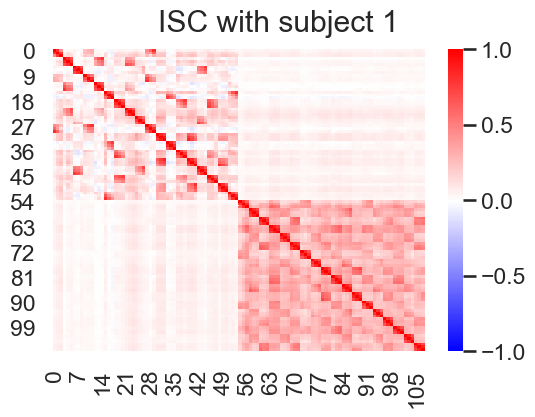

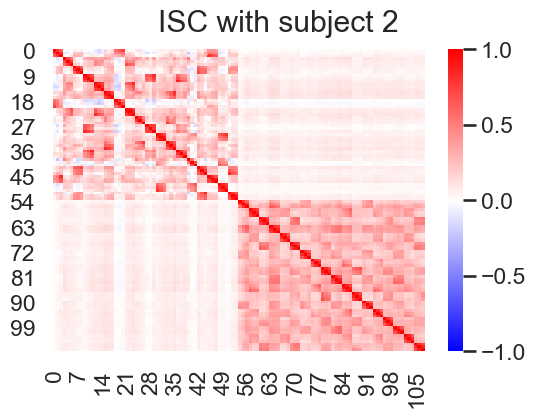

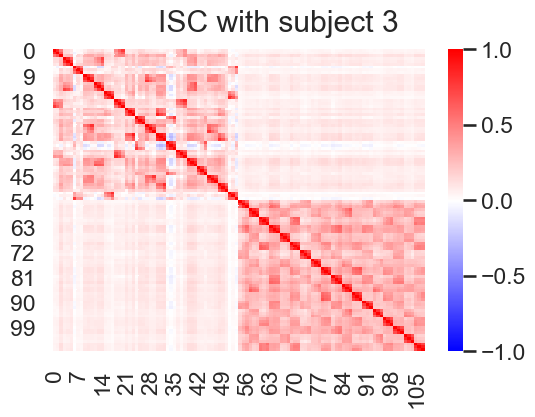

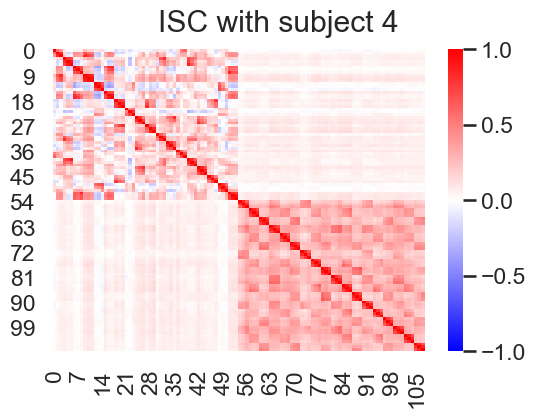

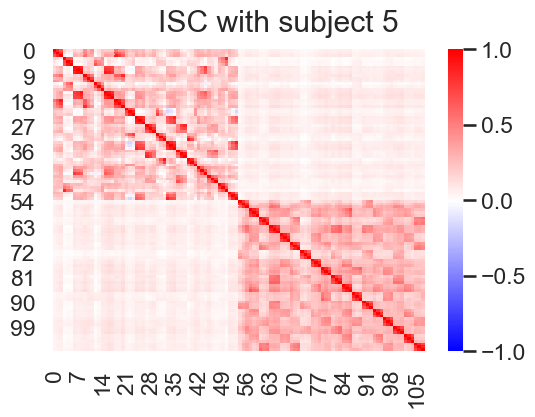

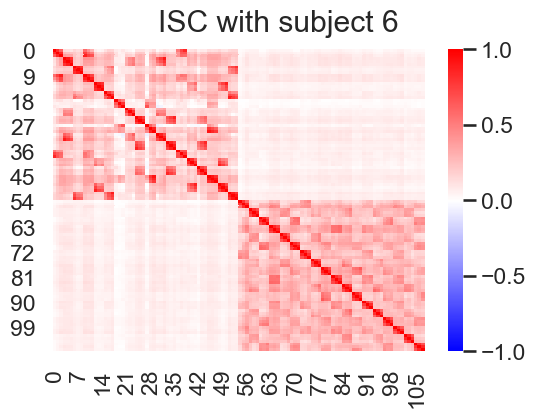

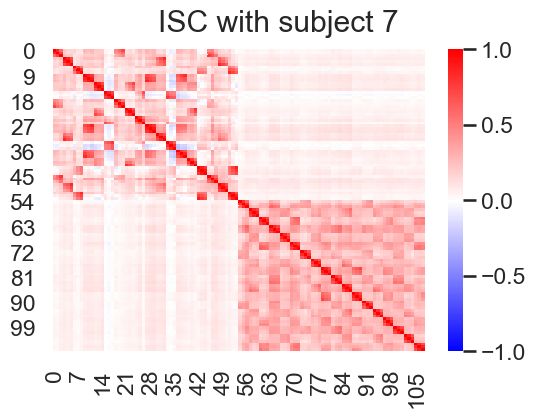

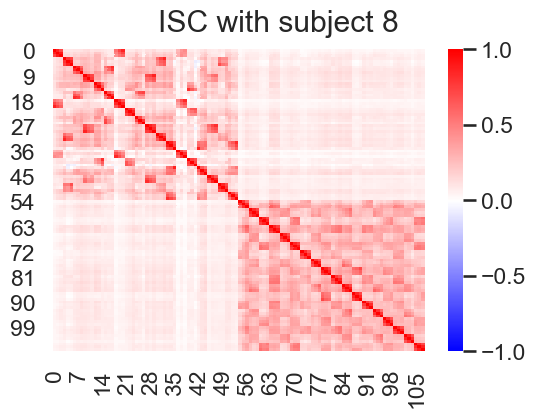

In [23]:
for i in range(num_subjects):
    
    M_sub = ISC_arr[:,:,i] # take the subject matrix 
    M_rest = np.delete(ISC_arr, i, axis=2) # remove this subjects' data from whole dataset
    # compute average of other matrices
    M_rest_mean = np.mean(M_rest, axis=2)

    # now compute correlation between mean matrix & subj matrix
    C_blockpatterns = np.corrcoef(M_sub, M_rest_mean, rowvar=True) # treat rows as variables
    
    f, ax = plt.subplots(1,1, dpi=100)
    f.suptitle(f'ISC with subject {i+1}')
    sns.heatmap(C_blockpatterns, cmap='bwr', ax=ax, vmin=-1, vmax=1);
    
## use this if want to trop upper half
#     mask = np.zeros_like(C_blockpatterns)
#     mask[np.triu_indices_from(mask)] = True
#     with sns.axes_style("white"):
#         f, ax = plt.subplots(1,1, dpi=100)
#         f.suptitle(f'ISC with subject {i+1}')
#         ax = sns.heatmap(C_blockpatterns, cmap='YlGnBu', mask=mask, vmax=.3, square=True)


## 3.2 ISC with Brainiak

- we have `ISC_arr` in the form `[levels, voxels, subjects] = (54, 179595, 8)`
- 

In [24]:
isc_maps = isc(ISC_arr, pairwise=False) # The output of ISC is a voxel by 
                           # participant matrix (showing the result of each individual with the group).